In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(".."))

Epoch 10/10 Loss: 0.000891 Test: 0.000533: 100%|██████████| 500/500 [00:00<00:00, 601.74it/s]


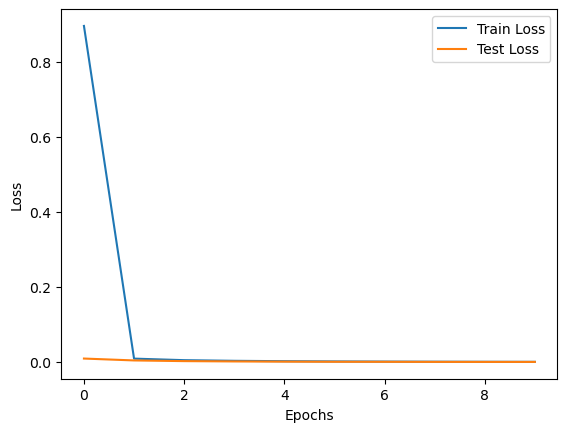

Model training completed successfully. Weights have been saved as 'baseline_mass_spring_damper.pth' in the 'weights' directory.


In [7]:
from dynamical_systems.mass_spring_damper_system import MassSpringDamperEnv
from models.feedforward_nn import FeedforwardNN
from sampling_methods.random_exploration import random_exploration
from train import create_dataloader, train_model
from utils import combine_datasets

import torch
import os

env = MassSpringDamperEnv(nlin=True, noise_var=0.01)

# Hyperparameters
NUM_TRAJECTORIES = 50
HORIZON = 500
BATCH_SIZE = 50
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
HIDDEN_SIZE = 64

# Collect data from the environment
train_dataset = random_exploration(env, HORIZON)
for _ in range(NUM_TRAJECTORIES-1):
    new_dataset = random_exploration(env, HORIZON)
    train_dataset = combine_datasets(train_dataset, new_dataset)
# Create DataLoader for training
train_dataloader = create_dataloader(train_dataset, BATCH_SIZE)
# Collect data for test set
test_dataset = random_exploration(env, HORIZON)
# Create DataLoader for training
test_dataloader = create_dataloader(test_dataset, HORIZON)

# Initialize the dynamics model
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
model = FeedforwardNN(state_dim, action_dim, hidden_size=HIDDEN_SIZE)

# Train the model
train_model(model, train_dataloader, test_dataloader, NUM_EPOCHS, LEARNING_RATE, plot=True)

# Ensure the 'weights' directory exists
os.makedirs('../weights', exist_ok=True)

# Save the trained model
torch.save(model.state_dict(), '../weights/baseline_mass_spring_damper.pth')
print("Model training completed successfully. "
      "Weights have been saved as 'baseline_mass_spring_damper.pth' in the 'weights' directory.")

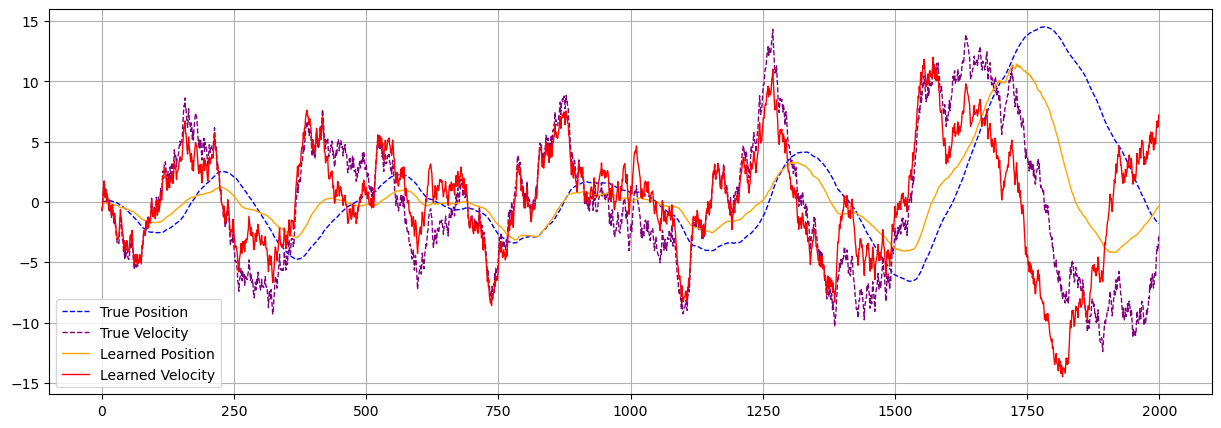

In [10]:
# test model
from dynamical_systems.mass_spring_damper_system import MassSpringDamperEnv

import numpy as np
import pygame
import matplotlib.pyplot as plt

# set random seed to get same test trajectory
test_seed = 44

# Using trained model as system dynamic
if __name__ == "__main__":
    # Initialize trained dynamics model
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    trained_model = FeedforwardNN(state_dim, action_dim, hidden_size=HIDDEN_SIZE)

    # load saved weights
    trained_model.load_state_dict(torch.load('../weights/baseline_mass_spring_damper.pth'))
    trained_model.eval()

    # learned dynamic
    trained_env = MassSpringDamperEnv(model=trained_model)
    trained_env.reset()
    env.reset()
    # env.action_space.seed(test_seed)
    save = [[],[]]
    # clock = pygame.time.Clock()
    for _ in range(2000):
        action = env.action_space.sample()
        obs, _, _, _, _= env.step(action)
        save[0].append(obs)
        obs, _, _, _, _= trained_env.step(action)
        save[1].append(obs)
        # clock.tick(400)
trained_env.close()

saved_traj = np.array(save)
plt.figure(1, (15,5))
plt.plot(saved_traj[0,:,0], label="True Position", color="blue", linestyle="--", linewidth=1)
plt.plot(saved_traj[0,:,1], label="True Velocity", color="purple", linestyle="--", linewidth=1)
plt.plot(saved_traj[1,:,0], label="Learned Position", color="orange", linewidth=1)
plt.plot(saved_traj[1,:,1], label="Learned Velocity", color="red", linewidth=1)
plt.legend()
plt.grid(True)
plt.show()

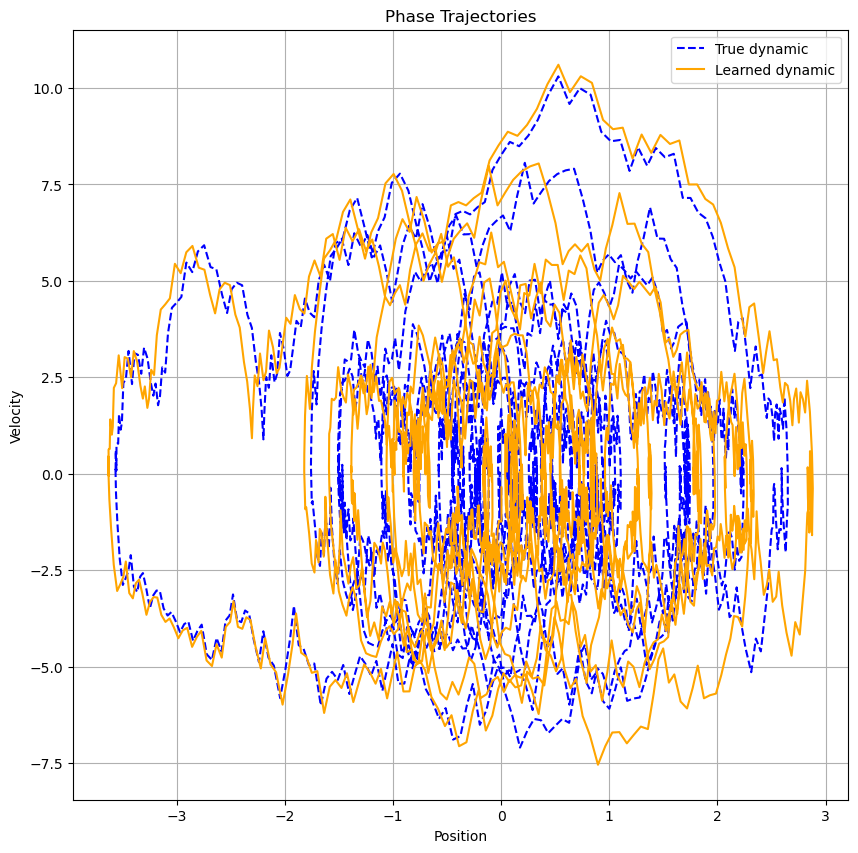

In [11]:
# Plot Phase Trajectories (Position vs Velocity)
plt.figure(2, (10, 10))
plt.plot(saved_traj[0,:,0], saved_traj[0,:,1], label="True dynamic", color="blue", linestyle="--")
plt.plot(saved_traj[1,:,0], saved_traj[1,:,1], label="Learned dynamic", color="orange")
plt.legend()
plt.grid(True)
plt.title("Phase Trajectories")
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.show()

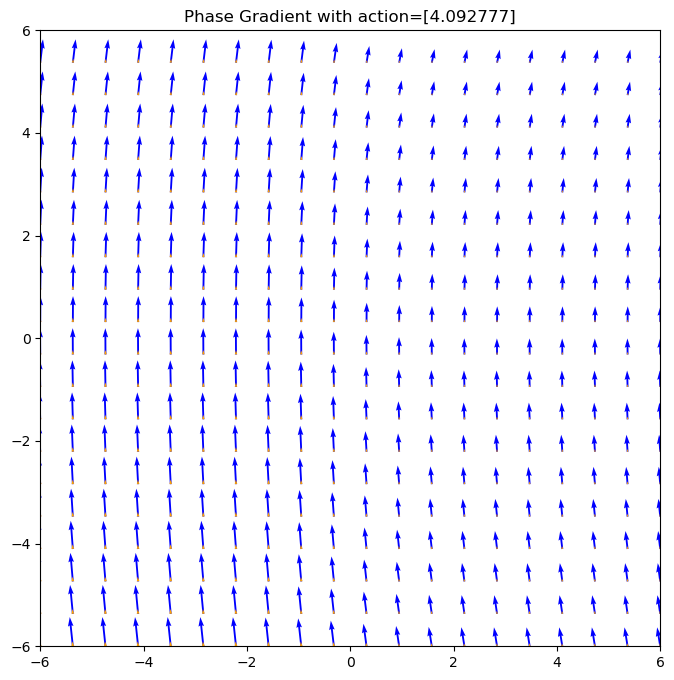

In [12]:
# plot phase gradient 
low, high = env.observation_space.low, env.observation_space.high
x = np.linspace(low[0], high[0], 20) # x as horizontal
v = np.linspace(low[1], high[1], 20) # v as vertical
X, V = np.meshgrid(x, v)
X_dot = np.zeros_like(X)
V_dot = np.zeros_like(V)
X_dot_trained = np.zeros_like(X)
V_dot_trained = np.zeros_like(V)
action = env.action_space.sample() # for one given action
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        start_state = np.array([X[i,j], V[i,j]])
        env.reset(state=start_state)
        obs, _, _, _, _= env.step(action)
        X_dot[i,j], V_dot[i,j] = obs-start_state
        start_state = np.array([X[i,j], V[i,j]])
        trained_env.reset(state=start_state)
        obs, _, _, _, _= trained_env.step(action)
        X_dot_trained[i,j], V_dot_trained[i,j] = obs-start_state

plt.figure(figsize=(8, 8))
plt.quiver(X, V, X_dot, V_dot, angles='xy', scale_units='xy', scale=1, color='blue')
plt.quiver(X, V, X_dot_trained, V_dot_trained, angles='xy', scale_units='xy', scale=6, color='orange')
plt.xlim(low[0], high[0])
plt.ylim(low[1], high[1])
plt.title(f'Phase Gradient with action={action}')
plt.show()